# Comparer distance Courte /  distance pollen fev mai


### Joindre la colonne de pollen au fichier avec les itinéraires aléatoires 

In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../script_python")
from data_utils import *
from function_utils import *

sys.path.append("../../../")
from global_variable import *
import os
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import scipy.stats as stats


# from notebook.data_loading.network_loading import load_network_from_gpkg
# from notebook.data_loading.itineraires_loading import load_itineraires_from_csv

# # Charger les données 
# edges, nodes = load_network_from_gpkg(final_network_pollen_fevmai_path)

gpkg_path = globpath("./score_calculation_it/output_data/network/graph/final_network_pollen_fevmai.gpkg")
edges = gpd.read_file(gpkg_path, layer="edges")
nodes = gpd.read_file(gpkg_path, layer="nodes")

# Vérifier que les colonnes nécessaires existent
required_columns = {"u", "v", "score_distance_pollen", "length", "oneway"}
missing_columns = required_columns - set(edges.columns)
if missing_columns:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans le fichier edges : {missing_columns}")

# Charger le fichier CSV contenant les itinéraires optimisés en distance
itineraire = globpath("./score_calculation_it/notebook/generation_it/itinéraire_court.csv")
itinéraire_court_pollen_fevmai = pd.read_csv(itineraire)

#itineraires = load_itineraires_from_csv(itineraire)


# Construction du graph
G_pollen = nx.DiGraph()
for _, row in edges.iterrows():
    G_pollen.add_edge(row['u'], row['v'], weight=row['score_distance_pollen'], length=row['length'])
    if not row['oneway']:
        G_pollen.add_edge(row['v'], row['u'], weight=row['score_distance_pollen'], length=row['length'])

# Vérifier que tous les start_nodes et end_nodes sont bien dans G_pollen
nodes_in_graph = set(G_pollen.nodes)
itinéraire_court_pollen_fevmai = itinéraire_court_pollen_fevmai[itinéraire_court_pollen_fevmai["start_node"].isin(nodes_in_graph) & itinéraire_court_pollen_fevmai["end_node"].isin(nodes_in_graph)]

# Calcul itinéraire minimisant le score_distance_pollen (sans stocker le chemin)
def compute_least_pollen_score(start, end):
    """
    Calcule la somme du score_distance_pollen et la distance totale du chemin minimisant le pollen entre deux nœuds.
    """
    try:
        path = nx.shortest_path(G_pollen, source=start, target=end, weight="weight")
        pollen_score = sum(G_pollen[path[i]][path[i+1]]["weight"] for i in range(len(path)-1))
        total_distance = sum(G_pollen[path[i]][path[i+1]]["length"] for i in range(len(path)-1))
        return pollen_score, total_distance
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan, np.nan

# Exécuter en parallèle
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(lambda row: compute_least_pollen_score(getattr(row, "start_node"), getattr(row, "end_node")), itinéraire_court_pollen_fevmai.itertuples(index=False)))

# Ajouter les résultats au DataFrame
itinéraire_court_pollen_fevmai["pollen_score"], itinéraire_court_pollen_fevmai["distance_pollen"] = zip(*results)

# Calcul de pollen_court
def compute_pollen_court(start, end):
    try:
        path = nx.shortest_path(G_pollen, source=start, target=end, weight="length")
        pollen_court = sum(G_pollen[path[i]][path[i+1]]["weight"] for i in range(len(path)-1))
        return pollen_court
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan

# Exécuter en parallèle pour pollen_court
with ThreadPoolExecutor(max_workers=4) as executor:
    pollen_court_results = list(executor.map(lambda row: compute_pollen_court(getattr(row, "start_node"), getattr(row, "end_node")), itinéraire_court_pollen_fevmai.itertuples(index=False)))

itinéraire_court_pollen_fevmai["pollen_court"] = pollen_court_results

# Supprimer les itinéraires où aucun chemin n'a été trouvé
itinéraire_court_pollen_fevmai = itinéraire_court_pollen_fevmai.dropna(subset=["pollen_score", "distance_pollen", "pollen_court"])

# Sauvegarde et visualisation
itinéraire_court_pollen_fevmai.to_csv("itineraire_court_pollen.csv", index=False)

print(f"\n Calcul terminé : {len(itinéraire_court_pollen_fevmai)} itinéraires enregistrés dans 'itineraire_court_pollen.csv' !")


current_month 3

 Calcul terminé : 1082 itinéraires enregistrés dans 'itineraire_court_pollen.csv' !


In [2]:
itinéraire_court_pollen_fevmai

,start_node,end_node,distance_court,pollen_score,distance_pollen,pollen_court
0,3380751025,5657136849,2742.877,4411.334267,3038.538,6241.833067
1,11356942377,171760149,1910.433,1909.474000,1909.474,1909.474000
2,2225197158,4463347218,3511.353,5357.101000,4639.978,5621.505667
3,7603662257,8913559675,875.318,5741.693000,898.929,5873.202000
4,6915264516,373344984,1826.830,5954.111438,2952.563,11395.915033
...,...,...,...,...,...,...
1081,1474023346,2109760437,2821.256,3707.826000,3138.206,4496.500556
1082,1357967486,591898696,3091.884,8154.486000,3623.676,11107.962611
1084,976140519,7356888324,1362.956,2529.774500,1863.696,2607.552167
1085,11197666281,2838044698,3505.793,3733.185000,3505.793,3733.185000


In [3]:
print_statistics(itinéraire_court_pollen_fevmai, ["distance_court", "distance_pollen"])


Statistiques Descriptives:
       distance_court  distance_pollen
count     1082.000000      1082.000000
mean      2273.035513      2708.457521
std        998.116068      1332.219116
min        600.642000       600.642000
25%       1392.598750      1566.765000
50%       2260.035500      2631.227000
75%       3150.756250      3720.946750
max       3999.758000      7648.746000


# Visualisation

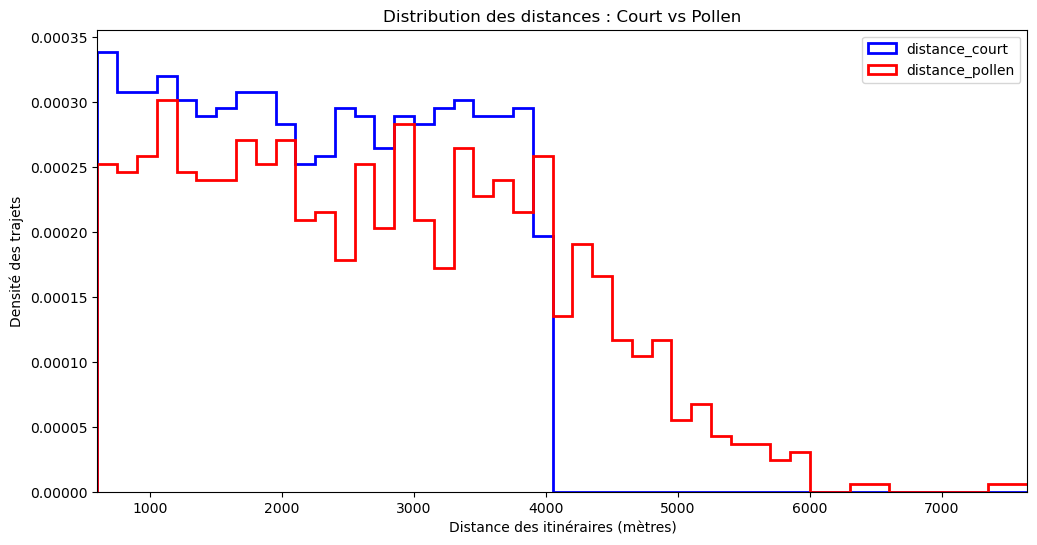

In [4]:
plot_histogram(itinéraire_court_pollen_fevmai, 
               col_x="distance_court", 
               col_y="distance_pollen", 
               xlabel="Distance des itinéraires (mètres)", 
               ylabel="Densité des trajets", 
               title="Distribution des distances : Court vs Pollen")

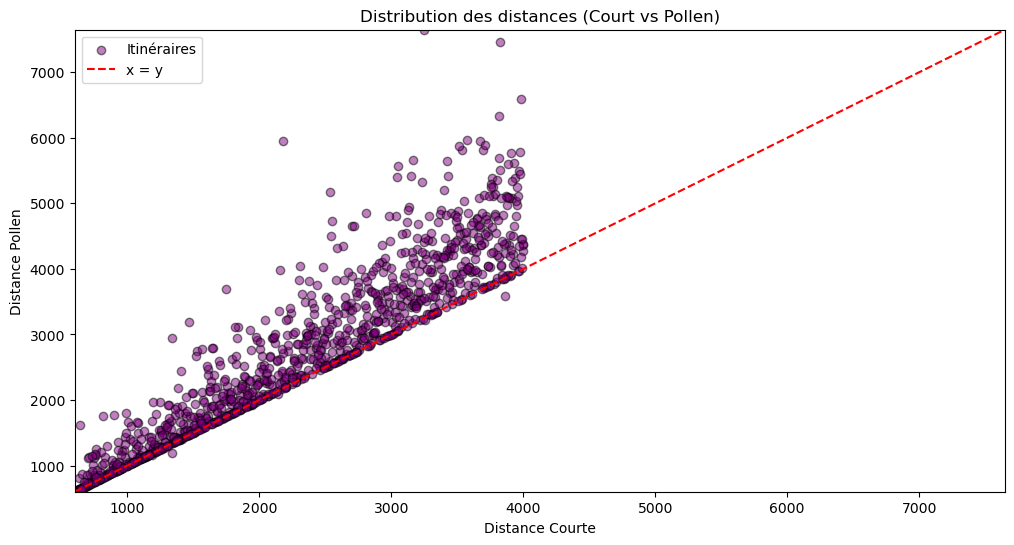

In [5]:
plot_scatter(itinéraire_court_pollen_fevmai, "distance_court", "distance_pollen", 
         label_x="Distance Courte", label_y="Distance Pollen", 
         title="Distribution des distances (Court vs Pollen)")


#### Test global 

In [6]:
# Vérifier si `distance_pollen` est globalement plus grande que `distance_court`
moyenne_distance_court = itinéraire_court_pollen_fevmai["distance_court"].mean()
moyenne_distance_pollen = itinéraire_court_pollen_fevmai["distance_pollen"].mean()

# Affichage des résultats globaux
global_results_pollen_fevmai = pd.DataFrame({
    "Moyenne Distance Court": [moyenne_distance_court],
    "Moyenne Distance Pollen": [moyenne_distance_pollen],
    "Différence Absolue": [moyenne_distance_pollen - moyenne_distance_court],
    "Différence Relative (%)": [(moyenne_distance_pollen - moyenne_distance_court) / moyenne_distance_court * 100]
})

print("\n COMPARAISON DES DISTANCES ")
print(global_results_pollen_fevmai)


 COMPARAISON DES DISTANCES 
   Moyenne Distance Court  Moyenne Distance Pollen  Différence Absolue  \
0             2273.035513              2708.457521          435.422008   

   Différence Relative (%)  
0                 19.15597  


In [7]:
# Définition du pas de 148m
step_size = 300

# Définition des bornes min/max avec une marge pour inclure toutes les valeurs
min_distance = itinéraire_court_pollen_fevmai["distance_court"].min()
max_distance = itinéraire_court_pollen_fevmai["distance_court"].max()

# Création des intervalles de 148m en s'assurant que max_distance est bien inclus
bins = np.arange(min_distance, max_distance + step_size, step_size)

# Création des groupes avec pd.cut() en forçant l'inclusion des bornes
itinéraire_court_pollen_fevmai["distance_group"] = pd.cut(
    itinéraire_court_pollen_fevmai["distance_court"], bins, include_lowest=True
)

# Vérifier la taille des groupes
group_sizes = itinéraire_court_pollen_fevmai["distance_group"].value_counts().sort_index()
print("\nTAILLE DES GROUPES INITIAUX (PAS 148)")
print(group_sizes)



TAILLE DES GROUPES INITIAUX (PAS 148)
distance_group
(600.6410000000001, 900.642]    105
(900.642, 1200.642]             102
(1200.642, 1500.642]             96
(1500.642, 1800.642]             98
(1800.642, 2100.642]             96
(2100.642, 2400.642]             83
(2400.642, 2700.642]             95
(2700.642, 3000.642]             90
(3000.642, 3300.642]             94
(3300.642, 3600.642]             96
(3600.642, 3900.642]             95
(3900.642, 4200.642]             32
Name: count, dtype: int64


In [8]:
# Initialisation des résultats
results = []

# Calcul des statistiques pour chaque groupe
for group in itinéraire_court_pollen_fevmai["distance_group"].unique():
    subset = itinéraire_court_pollen_fevmai[itinéraire_court_pollen_fevmai["distance_group"] == group]

    # Test de Wilcoxon
    stat, p_value = wilcoxon(subset["distance_pollen"], subset["distance_court"], alternative='greater')

    # Calcul du d de Cohen
    d_value = cohen_d(subset["distance_pollen"], subset["distance_court"])

    # Ajout des résultats dans la liste
    results.append({
        "Intervalle de Distance": group, 
        "Nombre d'Itinéraires": len(subset),
        "Statistique Wilcoxon": stat,
        "p-value": p_value,
        "Cohen's d": d_value
    })

# Création du DataFrame final
distance_pollen_fevmai_results = pd.DataFrame(results)

# Affichage des résultats complets
distance_pollen_fevmai_results = distance_pollen_fevmai_results.sort_values(by="Intervalle de Distance", ascending=True)
distance_pollen_fevmai_results

,Intervalle de Distance,Nombre d'Itinéraires,Statistique Wilcoxon,p-value,Cohen's d
3,"(600.6410000000001, 900.642]",105,3089.5,7.961672e-13,0.499474
8,"(900.642, 1200.642]",102,2760.5,9.027255e-12,0.628494
9,"(1200.642, 1500.642]",96,3209.0,1.530424e-13,0.642114
5,"(1500.642, 1800.642]",98,3440.5,6.402675e-15,0.793648
1,"(1800.642, 2100.642]",96,3324.0,3.164203e-14,0.841899
10,"(2100.642, 2400.642]",83,2971.0,4.274610e-14,0.898061
7,"(2400.642, 2700.642]",95,3891.0,4.374427e-16,0.896722
0,"(2700.642, 3000.642]",90,3637.0,1.104674e-15,1.079045
4,"(3000.642, 3300.642]",94,4172.0,9.477142e-17,1.006862
2,"(3300.642, 3600.642]",96,4250.0,1.016465e-16,1.209125


- Plus la valeur de Statistique Wilcoxon est grande  plus distance_bruit est systématiquement plus grand que distance_court 

- p < seuil alpha la différence entre distance_bruit et distance_court est statistiquement significative

- d de Cohen : Taille de l'effet (Plus la valeur est grande plus la différence entre la distance des chemins courts et la distance des chemins ou on a minimisé le bruit est forte.)

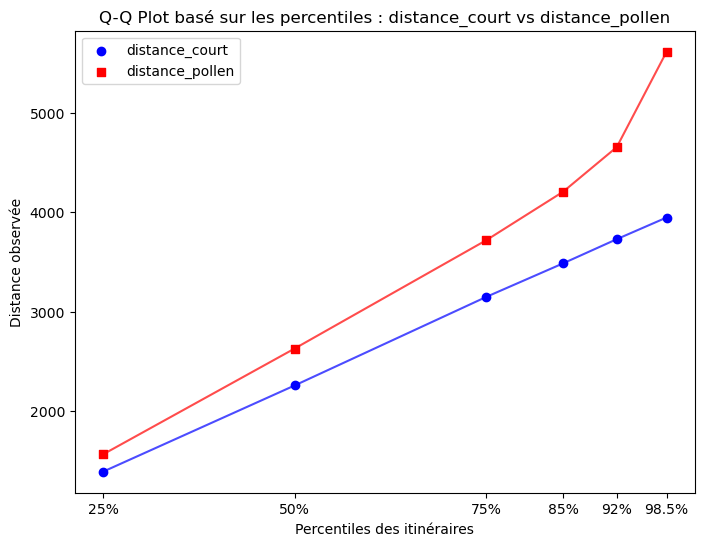

In [9]:
plot_qq(itinéraire_court_pollen_fevmai, col_court="distance_court", col_score="distance_pollen")

### Questions : 

- Combien d'itinéraires on une augmentation < à 30% 

- Combien d'itinéraires > à 30% 

- Quelle est la fréquence des itinéraires > à 30%

In [10]:
# Définition des quantiles à calculer
quantiles = [0.25, 0.5, 0.75, 0.85, 0.92, 0.985]

# Liste pour stocker les résultats
resultats_list = []


# Calcul de l'augmentation relative de la distance en %
itinéraire_court_pollen_fevmai["relative_distance_increase"] = (
    (itinéraire_court_pollen_fevmai["distance_pollen"] - itinéraire_court_pollen_fevmai["distance_court"]) / 
    itinéraire_court_pollen_fevmai["distance_court"]
) * 100

# Parcours de chaque groupe d'intervalle
for intervalle in itinéraire_court_pollen_fevmai["distance_group"].cat.categories:
    # Sélection des données correspondant à l'intervalle
    subset = itinéraire_court_pollen_fevmai[itinéraire_court_pollen_fevmai["distance_group"] == intervalle]

    

    # Calcul des quantiles pour l'augmentation relative de la distance
    quantiles_distance = subset["relative_distance_increase"].quantile(quantiles)

    # Calcul de la fréquence des itinéraires > 30% plus longs
    freq_plus_30 = (subset["relative_distance_increase"] > 30).mean() * 100

    # Nombre total de trajets dans cet intervalle
    total_trajets = len(subset)

    # Conversion du pourcentage en nombre d'itinéraires
    nombre_itineraires_sup_30 = int(freq_plus_30 / 100 * total_trajets)

    # Trouver le quantile le plus proche de 30 mais en dessous
    quantiles_below_30 = {f"Q{int(q*100)}": quantiles_distance[q] for q in quantiles if quantiles_distance[q] <= 30}
    quantile_proche_30 = max(quantiles_below_30, key=quantiles_below_30.get) if quantiles_below_30 else None

    # Création d'un dictionnaire avec les résultats
    result_dict = {
        "Intervalle": str(intervalle),  # Convertir en string pour un affichage clair
        "Q25": quantiles_distance[0.25],
        "Q50": quantiles_distance[0.5],
        "Q75": quantiles_distance[0.75],
        "Q85": quantiles_distance[0.85],
        "Q92": quantiles_distance[0.92],
        "Q98.5": quantiles_distance[0.985],
        "Quantile_≤_30": quantile_proche_30,  # Le quantile sous 30%
        "Fréquence_>_30%": freq_plus_30,
        "Nombre_itinéraires_>_30%": nombre_itineraires_sup_30  # Nombre d'itinéraires > 30%
    }

    # Ajouter le dictionnaire à la liste des résultats
    resultats_list.append(result_dict)

# Transformer les résultats en DataFrame final
df_resultats_final_pollen_fevmai = pd.DataFrame(resultats_list)
df_resultats_final_pollen_fevmai = df_resultats_final_pollen_fevmai.round(2)
df_resultats_final_pollen_fevmai

,Intervalle,Q25,Q50,Q75,Q85,Q92,Q98.5,Quantile_≤_30,Fréquence_>_30%,Nombre_itinéraires_>_30%
0,"(600.6410000000001, 900.642]",0.00,0.04,13.02,27.58,53.67,105.11,Q85,14.29,15
1,"(900.642, 1200.642]",0.00,1.07,17.05,30.82,45.49,64.73,Q75,15.69,16
2,"(1200.642, 1500.642]",0.00,5.19,23.46,30.97,43.76,98.72,Q75,16.67,15
3,"(1500.642, 1800.642]",0.00,10.42,26.03,35.16,53.37,79.16,Q75,22.45,22
4,"(1800.642, 2100.642]",0.00,9.17,20.62,31.23,45.15,65.96,Q75,15.62,15
5,"(2100.642, 2400.642]",3.90,16.48,33.52,45.73,53.66,82.47,Q50,27.71,23
6,"(2400.642, 2700.642]",1.38,13.05,27.59,35.46,48.50,82.11,Q75,17.89,17
7,"(2700.642, 3000.642]",5.11,14.26,31.50,38.50,43.63,71.87,Q50,27.78,25
8,"(3000.642, 3300.642]",7.71,17.25,31.74,40.29,57.47,81.11,Q50,26.60,25
9,"(3300.642, 3600.642]",8.32,19.05,27.49,36.68,42.45,66.26,Q75,21.88,21


In [11]:
print(f"Nombre total d'itinéraires ayant une augmentation > 30% : {df_resultats_final_pollen_fevmai["Nombre_itinéraires_>_30%"].sum()}")
print(f"Moyenne des fréquences > 30% : {df_resultats_final_pollen_fevmai["Fréquence_>_30%"].mean()}")

Nombre total d'itinéraires ayant une augmentation > 30% : 230
Moyenne des fréquences > 30% : 21.926666666666666


Interpretaion pour le premier intervalle :

- 98.5% des trajets ont une augmentation de distance ≤ 105%
- 14% des trajets dépassent 30% d'augmentation

# Comparaison des scores de pollen entre les itinéraires courts et minimisé pollen 

In [12]:
print_statistics(itinéraire_court_pollen_fevmai, ["pollen_court", "pollen_score"])


Statistiques Descriptives:
       pollen_court  pollen_score
count   1082.000000   1082.000000
mean    6444.397995   4529.864842
std     4524.262629   2679.413411
min      600.754000    600.754000
25%     2820.125274   2430.957879
50%     5431.888690   4121.101212
75%     9036.221397   6087.861251
max    26238.401384  13929.939600


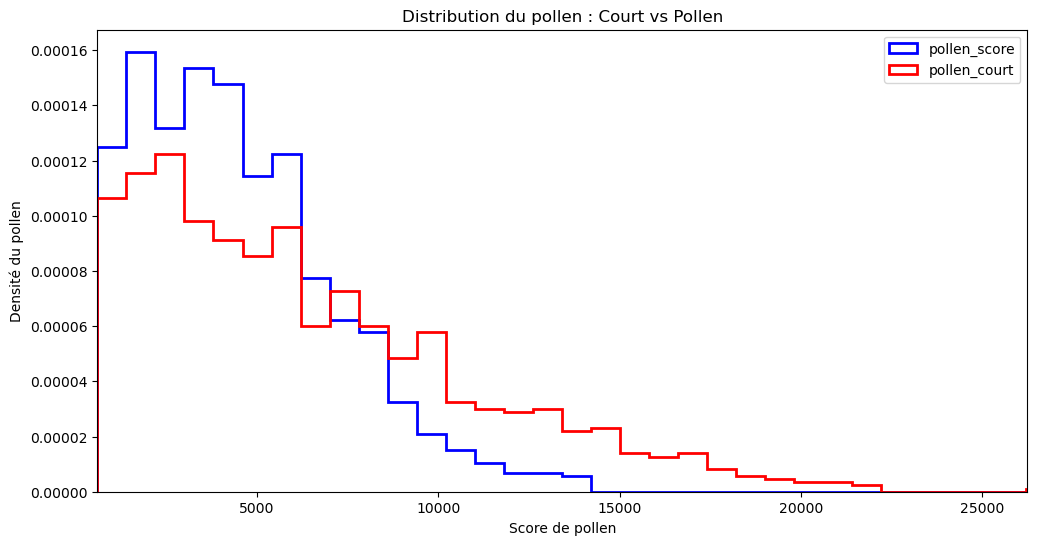

In [13]:
plot_histogram(itinéraire_court_pollen_fevmai, binwidth= 800,
               col_x="pollen_score", 
               col_y="pollen_court", 
               xlabel="Score de pollen", 
               ylabel="Densité du pollen", 
               title="Distribution du pollen : Court vs Pollen")

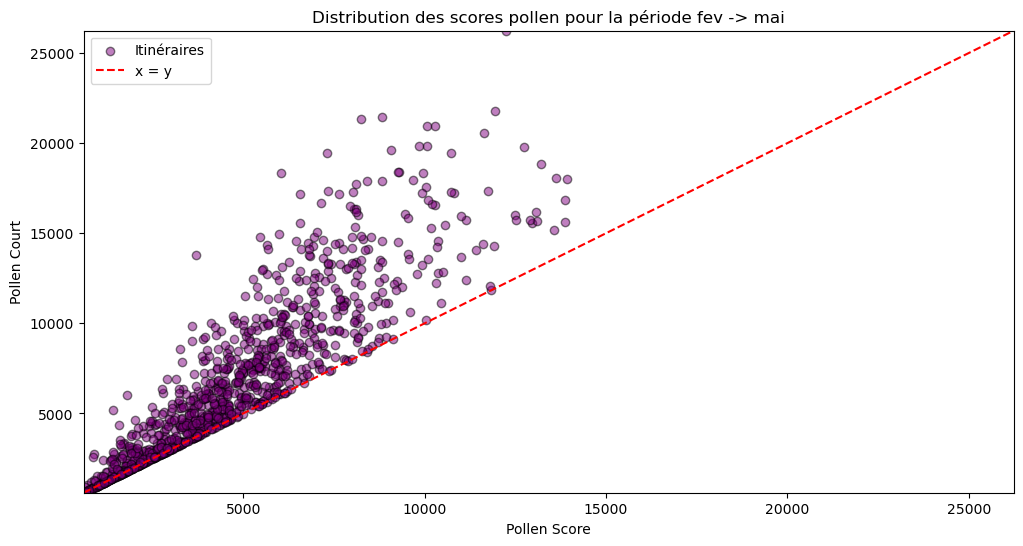

In [21]:
plot_scatter(itinéraire_court_pollen_fevmai, "pollen_score", "pollen_court", 
         label_x="Pollen Score", label_y="Pollen Court", 
         title="Distribution des scores pollen pour la période fev -> mai")



In [15]:
# Vérifier si `pollen_court` est globalement plus grande que `pollen_score`
moyenne_pollen_court = itinéraire_court_pollen_fevmai["pollen_court"].mean()
moyenne_pollen_score = itinéraire_court_pollen_fevmai["pollen_score"].mean()

# Affichage des résultats globaux
global_results_fevmai = pd.DataFrame({
    "Moyenne pollen Court": [moyenne_pollen_court],
    "Moyenne pollen Score": [moyenne_pollen_score],
    "Différence Absolue": [moyenne_pollen_court-moyenne_pollen_score],
    "Différence Relative (%)": [(moyenne_pollen_court-moyenne_pollen_score) / moyenne_pollen_court * 100]
})

print("\n COMPARAISON DU pollen")
print(global_results_fevmai)


 COMPARAISON DU pollen
   Moyenne pollen Court  Moyenne pollen Score  Différence Absolue  \
0           6444.397995           4529.864842         1914.533153   

   Différence Relative (%)  
0                29.708487  


In [16]:
# Définition du pas de 148m
step_size = 300

# Définition des bornes min/max avec une marge pour inclure toutes les valeurs
min_distance = itinéraire_court_pollen_fevmai["distance_court"].min()
max_distance = itinéraire_court_pollen_fevmai["distance_court"].max()

# Création des intervalles de 148m en s'assurant que max_distance est bien inclus
bins = np.arange(min_distance, max_distance + step_size, step_size)

# Création des groupes avec pd.cut() en forçant l'inclusion des bornes
itinéraire_court_pollen_fevmai["distance_group"] = pd.cut(
    itinéraire_court_pollen_fevmai["distance_court"], bins, include_lowest=True
)

# Vérifier la taille des groupes
group_sizes = itinéraire_court_pollen_fevmai["distance_group"].value_counts().sort_index()
print("\nTAILLE DES GROUPES INITIAUX (PAS 148)")
print(group_sizes)


TAILLE DES GROUPES INITIAUX (PAS 148)
distance_group
(600.6410000000001, 900.642]    105
(900.642, 1200.642]             102
(1200.642, 1500.642]             96
(1500.642, 1800.642]             98
(1800.642, 2100.642]             96
(2100.642, 2400.642]             83
(2400.642, 2700.642]             95
(2700.642, 3000.642]             90
(3000.642, 3300.642]             94
(3300.642, 3600.642]             96
(3600.642, 3900.642]             95
(3900.642, 4200.642]             32
Name: count, dtype: int64


In [17]:
# Initialisation des résultats pour Wilcoxon
results = []

# Calcul des statistiques pour chaque groupe (pollen_court vs pollen_score)
for group in itinéraire_court_pollen_fevmai["distance_group"].unique():
    subset = itinéraire_court_pollen_fevmai[itinéraire_court_pollen_fevmai["distance_group"] == group]

    # Test de Wilcoxon pour vérifier si pollen_score est inférieur à pollen_court
    stat, p_value = wilcoxon(subset["pollen_score"], subset["pollen_court"], alternative='less')

    # Calcul du d de Cohen
    mean_diff = subset["pollen_court"].mean() - subset["pollen_score"].mean()
    pooled_std = np.sqrt((subset["pollen_court"].std() ** 2 + subset["pollen_score"].std() ** 2) / 2)
    d_value = mean_diff / pooled_std if pooled_std > 0 else np.nan  # Éviter la division par zéro

    # Ajout des résultats dans la liste
    results.append({
        "Intervalle de Distance": group,
        "Nombre d'Itinéraires": len(subset),
        "Statistique Wilcoxon": stat,
        "p-value": p_value,
        "Cohen's d": d_value
    })

# Création du DataFrame final avec les résultats
pollen_fevmai_results = pd.DataFrame(results)
pollen_fevmai_results = pollen_fevmai_results.sort_values(by="Intervalle de Distance", ascending=True)
pollen_fevmai_results

,Intervalle de Distance,Nombre d'Itinéraires,Statistique Wilcoxon,p-value,Cohen's d
3,"(600.6410000000001, 900.642]",105,0.0,8.128492e-11,0.319496
8,"(900.642, 1200.642]",102,0.0,8.128492e-11,0.429985
9,"(1200.642, 1500.642]",96,0.0,1.202553e-12,0.507472
5,"(1500.642, 1800.642]",98,0.0,1.214880e-13,0.556032
1,"(1800.642, 2100.642]",96,0.0,2.607463e-13,0.565185
10,"(2100.642, 2400.642]",83,0.0,2.607463e-13,0.804012
7,"(2400.642, 2700.642]",95,0.0,1.231415e-14,0.776010
0,"(2700.642, 3000.642]",90,0.0,8.410875e-15,0.795035
4,"(3000.642, 3300.642]",94,0.0,2.730091e-16,0.910436
2,"(3300.642, 3600.642]",96,0.0,8.553276e-16,1.008910


#### Stat Wilcoxon :
Plus la valeur est grande plus le bruit des chemins courts est supérieur à celui des chemins ou on a minimisé le bruit, donc plus l’optimisation du bruit est efficace

#### P_Value : 

Plus la valeur est faible plus la réduction du bruit est statistiquement significative (5%)

#### Cohen : 

Plus la valeur est grande plus la différence entre le bruit des chemins courts et le bruit des chemins ou on a minimisé le bruit est forte. Un grand effet indique une forte réduction du bruit.

## A partir de 1200m, commence vraiment à augmenter (Modéré -> Fort), l'effet devient plus fort au dela de 1200 m.

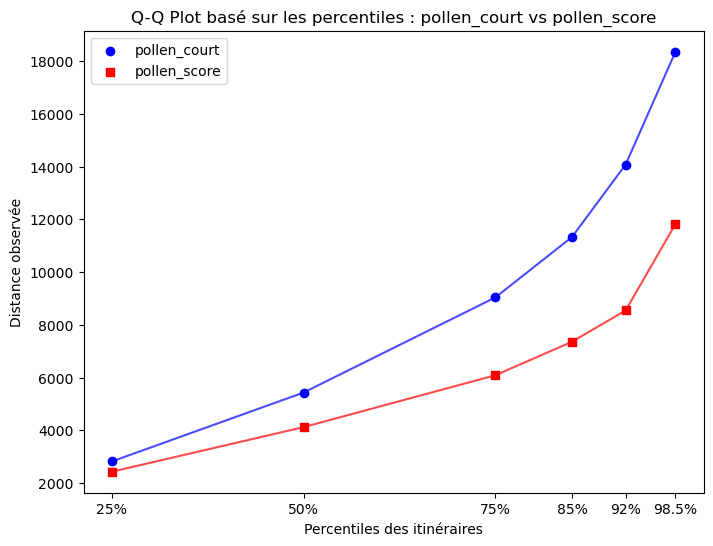

In [18]:
plot_qq(itinéraire_court_pollen_fevmai, col_court="pollen_court", col_score="pollen_score")

## Mesure la réduction du pollen 

(pollen_court - pollen_score)

Question : Pour chaque intervalle quelle est la réduction moyenne du bruit en % ?

In [19]:
# Définition des quantiles à calculer
quantiles = [0.25, 0.5, 0.75, 0.85, 0.92, 0.985]

# Liste pour stocker les résultats
resultats_pollen_fevmai = []

# Parcours de chaque groupe d'intervalle
for intervalle in itinéraire_court_pollen_fevmai["distance_group"].cat.categories:
    # Sélection des données correspondant à l'intervalle (avec .copy() pour éviter SettingWithCopyWarning)
    subset = itinéraire_court_pollen_fevmai[itinéraire_court_pollen_fevmai["distance_group"] == intervalle].copy()

    # Calcul de la réduction du pollen (absolue)
    subset.loc[:, "réduction_pollen"] = subset["pollen_court"] - subset["pollen_score"]

    # Calcul de la réduction du pollen en pourcentage
    subset.loc[:, "réduction_pollen_%"] = (subset["réduction_pollen"] / subset["pollen_court"]) * 100

    # Calcul du gain par mètre (réduction du pollen divisée par la distance de l'itinéraire court)
    subset.loc[:, "gain_par_mètre"] = subset["réduction_pollen"] / subset["distance_court"]

    # Calcul des quantiles pour la réduction du pollen et le gain par mètre
    quantiles_pollen_pct = subset["réduction_pollen_%"].quantile(quantiles)
    quantiles_gain_m = subset["gain_par_mètre"].quantile(quantiles)

    # Calcul de la moyenne de la réduction du pollen et du gain par mètre
    moyenne_réduction_pollen_pct = subset["réduction_pollen_%"].mean()
    moyenne_gain_par_mètre = subset["gain_par_mètre"].mean() # Peut etre en % ?

    # Création d'un dictionnaire avec les résultats
    result_pollen_fevmai_dict = {
        "Intervalle": str(intervalle),  # Convertir en string pour un affichage clair
        "Q25 (Pollen %)": quantiles_pollen_pct[0.25],
        "Q50 (Pollen %)": quantiles_pollen_pct[0.5],
        "Q75 (Pollen %)": quantiles_pollen_pct[0.75],
        "Q85 (Pollen %)": quantiles_pollen_pct[0.85],
        "Q92 (Pollen %)": quantiles_pollen_pct[0.92],
        "Q98.5 (Pollen %)": quantiles_pollen_pct[0.985],
        "Moyenne Réduction Pollen %": moyenne_réduction_pollen_pct,
        "Moyenne Gain par mètre": moyenne_gain_par_mètre

    }

    # Ajouter le dictionnaire à la liste des résultats
    resultats_pollen_fevmai.append(result_pollen_fevmai_dict)

# Transformer les résultats en DataFrame final
df_resultats_pollen_fevmai = pd.DataFrame(resultats_pollen_fevmai)
df_resultats_pollen_fevmai = df_resultats_pollen_fevmai.round(2)

df_resultats_pollen_fevmai

,Intervalle,Q25 (Pollen %),Q50 (Pollen %),Q75 (Pollen %),Q85 (Pollen %),Q92 (Pollen %),Q98.5 (Pollen %),Moyenne Réduction Pollen %,Moyenne Gain par mètre
0,"(600.6410000000001, 900.642]",0.00,0.29,25.65,33.40,39.38,56.84,12.84,0.43
1,"(900.642, 1200.642]",0.00,1.06,24.33,42.40,49.13,59.21,14.45,0.54
2,"(1200.642, 1500.642]",0.00,11.03,29.99,40.07,44.58,56.09,16.58,0.55
3,"(1500.642, 1800.642]",0.00,15.50,32.70,36.22,44.86,56.97,18.25,0.65
4,"(1800.642, 2100.642]",0.00,16.55,32.74,41.45,45.48,61.27,19.23,0.67
5,"(2100.642, 2400.642]",8.87,25.09,36.19,42.02,46.07,57.21,24.05,0.89
6,"(2400.642, 2700.642]",4.71,21.34,37.65,46.15,52.88,57.35,23.20,0.81
7,"(2700.642, 3000.642]",5.30,25.39,37.13,44.34,50.62,57.72,24.09,0.82
8,"(3000.642, 3300.642]",15.04,27.66,39.95,45.74,50.70,58.70,26.95,0.97
9,"(3300.642, 3600.642]",11.59,27.02,42.57,45.82,49.94,55.07,27.15,0.93


In [23]:
print(f"Moyenne Réduction pollen > 30% : {df_resultats_pollen_fevmai["Moyenne Réduction Pollen %"].mean()}")
print(f"Moyenne Gain par mètre: {df_resultats_pollen_fevmai["Moyenne Gain par mètre"].mean()}")

Moyenne Réduction pollen > 30% : 22.044166666666666
Moyenne Gain par mètre: 0.7808333333333333


## En dessous de 1500m, la réduction du pollen reste modérée
## À partir de 1500m, la réduction devient plus significative
## Au-delà de 2100m, l’effet de la distance devient beaucoup plus fort
## Le maximum est atteint entre 3900-4200m avec 30% de réduction moyenne et un gain de 1.06% par mètre

Interpretation pour la première intervalle : 

- 50% des itinéraires ont une réduction du pollen de 0.29% ou moins 

- 98.5% des itinéraires ont une réduction du pollen inférieure à 56.84%.
 
- En moyenne les itinéraires réduisent le pollen de 12.84%

- En moyenne les itinéraires on un gain de 0.43 par mètre